## Fastai Foundations MatMul, Broadcasting

In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [45]:
#export 
from exp.nb_00 import *
import operator

def test(a, b, cmp, cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a, b),f"{cname}:\n{a}\n{b}"

def test_eq(a, b): test(a,b,operator.eq,'==')

In [46]:
test_eq(TEST,'test')

In [143]:
#export 
from pathlib import Path
from IPython.core.debugger import set_trace
# from fastai import datasets
import torchvision.datasets as datasets
import pickle,gzip,math,torch,matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import torchvision.datasets as datasets


In [48]:
import torchvision.datasets as datasets

In [15]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

9913344it [00:01, 7525496.25it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



29696it [00:00, 22984693.04it/s]         


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



1649664it [00:00, 6357477.40it/s]                             


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



5120it [00:00, 16318264.80it/s]         

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/Caskroom/miniforge/base/envs/ml_env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-4zyfwhmc/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [19]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [49]:
mnist_trainset.data.shape

torch.Size([60000, 28, 28])

In [50]:
mnist_testset.data.shape

torch.Size([10000, 28, 28])

In [41]:
x_train = mnist_trainset.data.reshape(mnist_trainset.data.shape[0], 784)

In [52]:
x_train, x_valid = x_train[:50000], x_train[50000:]
print(x_train.shape, x_valid.shape)

torch.Size([50000, 784]) torch.Size([10000, 784])


In [53]:
y_train, y_valid = mnist_trainset.targets[:50000], mnist_trainset.targets[50000:]
print(y_train.shape, y_valid.shape)

torch.Size([50000]) torch.Size([10000])


In [42]:
x_train.shape

torch.Size([60000, 784])

In [31]:
mpl.rcParams['image.cmap'] = 'gray'

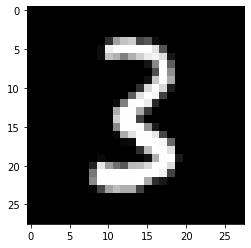

In [54]:
plt.imshow(x_valid[0].view((28,28)))

In [55]:
print(y_valid[0])

tensor(3)


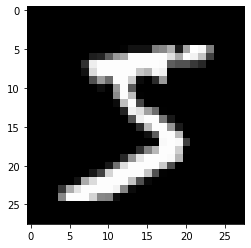

In [32]:
plt.imshow(mnist_trainset.data[0])

In [ ]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

In [ ]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [ ]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

matrixmultiplication.xyz

## Initial python model

In [33]:
weights = torch.randn(784, 10)

In [34]:
bias = torch.zeros(10)

### Matrix Multiplication

In [35]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc) # result shape
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i, j] += a[i, k] * b[k, j]
    return c

In [56]:
m1 = x_valid[:5]
m2 = weights

In [57]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [58]:
%time t1 = matmul(m1,m2)

CPU times: user 230 ms, sys: 4.57 ms, total: 235 ms
Wall time: 250 ms


In [60]:
print(t1.shape, len(x_train))

torch.Size([5, 10]) 50000


Elementwise ops

In [61]:
a = tensor([10.,6, -4])
b = tensor([2.,8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [62]:
a + b

tensor([12., 14.,  3.])

In [63]:
(a < b).float().mean()

tensor(0.6667)

In [65]:
m = tensor([[1.,2,3],[4,5,6],[7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [66]:
# Frobenius norm
(m*m).sum().sqrt()

tensor(16.8819)

In [76]:
# here we use broadcasting to reduce the number of operations | remove a loop
def matmul2(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc) # result shape
    for i in range(ar):
        for j in range(bc):            
            c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

In [79]:
%timeit -n 10 _= matmul2(m1,m2)

359 µs ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
#export 
def near(a,b): return torch.allclose(a,b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near) 

In [82]:
test_near(t1, matmul2(m1,m2))

## Broadcasting

In [83]:
a

tensor([10.,  6., -4.])

In [84]:
a > 0

tensor([ True,  True, False])

In [85]:
a + 1

tensor([11.,  7., -3.])

In [86]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [87]:

2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

In [88]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [89]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [90]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [91]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [92]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [94]:
t = c.expand_as(m); t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [95]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [96]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

The variable t only uses a vectors worth of storage in addition to a stride parameter to create a matrix representation that uses less memory.

So we have tensors that behave like higher ranked things than they are actually stored as.

In [97]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [98]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [99]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

The 1 will be added to the dim of the parameter e.g. if param is 0 it will be added to the first position, if 1 to the second.

In [100]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [103]:
# 2 and 3 are the same
c.shape, c[None,:].shape, c[None].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [104]:
# ... means all preceeding dimensions
c[None].shape, c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [107]:
c

tensor([10., 20., 30.])

In [106]:
c[:, None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [109]:
c[None,:].expand_as(m)

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [110]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [111]:
c[None,:] + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [117]:
c[None, None, :].shape

torch.Size([1, 1, 3])

In [112]:
c[...,None] + m

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [115]:
def matmul3(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc) # result shape

    for i in range(ar):
        #c[i] = (a[i, :] * b[:, j]).sum()
        # c[i, :] = (a[i,None] * b).sum(dim=0)
        # we sum over the rows to get the result hence the dim=0
        c[i] = (a[i ].unsqueeze(-1) * b).sum(dim=0) # unsqueezing the last dimension 
    return c

## 3200 x faster than the 3 loop Python solution

In [116]:
%timeit -n 10 _= matmul3(m1,m2)

55.5 µs ± 6.74 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Its different when we have a) c[None,:] (1,3) * b) c[:,None] (3,1) , you'd expect a 1*1 result but instead get a 3x3 matrix

This is because a) the row vector is broadcast to have the same number of rows as b) and b) the column vector is broadcast to have the same number of columns as the row vector

a) gets more rows
b) gets more columns

```
a) -> a+)
10 20 30

10 20 30
10 20 30
10 20 30

b) -> b+)
10
20
30

10 10 10
20 20 20
30 30 30

resulting in a 3x3 matrix

100 200 300
200 400 600
300 600 900
```

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the trailing dimensions, and works its way forward. Two dimensions are compatible when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a 256*256*3 array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

### The empty spaces are replaced by 1

```
Image  (3d array): 256 x 256 x 3
Scale  (1d array):             3
Result (3d array): 256 x 256 x 3
```

Note that in Pytorch the leading dim is the channel.

## Broadcasting is important because it helps us write concise code that is fast enough to be usefull.

## Eistein summation

A compact representationf or combining products and sums in a general way. 

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i'm a, b)` is equivalent to `np.inner(a,b` "

Notes on Einsum:

- Before the arrow we have the inputs, after the arrow we have the outputs
- The number of inputs is determined by the number of items delimited by the comma
- The rank of the items is determined the number of letters, where the sizes are determined by the letters
- Dot products are done over the shared k dimensions

## Pytorh has good docs on Einsum with examples

example for batchwise MatMul
` return torch.einsum('bik,bkj->bij', a, b) `

In [121]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()

def matmulE(a,b): return torch.einsum('ik,kj->ij',a,b)

In [124]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [126]:
m1.type(), m2.type()

('torch.ByteTensor', 'torch.FloatTensor')

In [129]:
m1 = m1.type(torch.FloatTensor)

In [130]:
%timeit -n 10 _ = matmulE(m1, m2)

26.4 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Pytorch Op

In [135]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 7.08 times longer than the fastest. This could mean that an intermediate result is being cached.
14.7 µs ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


%timeit -n 10 t2 = m1@m2

In [136]:
%timeit -n 10 _= m1@m2

6.87 µs ± 2.44 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [144]:
!python notebook2script.py 01_matmul.ipynb

Converted 01_matmul.ipynb to exp/nb_01.py
